# Test Filtering using Irregular Cartesian Laplacian with Land Mask (on casper)

In [30]:
import gcm_filters
import numpy as np
import cupy as cp
import xarray as xr
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

### Open 1/8 degree NeverWorld2 data

In [31]:
run = 26 #1/8 deg
end_time = 31500

st = xr.open_dataset('/glade/p/univ/unyu0004/neerajab/NeverWorld2/run%i/static.nc' % (run), decode_times=False) 

chunks = {'time': 20} 
av = xr.open_dataset('/glade/p/univ/unyu0004/neerajab/NeverWorld2/run%i/averages_000%i.nc' % (run,end_time-500+2), 
                     chunks=chunks, decode_times=False)

In [32]:
Nx = np.size(st.xh)
Ny = np.size(st.yh)

### Grid info

In [33]:
wet_mask = st.wet
area=st.area_t

dxw = xr.DataArray(data=st.dxCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dyw = xr.DataArray(data=st.dyCu.isel(xq=slice(0,Nx)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dxs = xr.DataArray(data=st.dxCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))
dys = xr.DataArray(data=st.dyCv.isel(yq=slice(0,Ny)),coords={'yh':av.yh,'xh':av.xh}, dims=('yh','xh'))

Note that a simple renaming of the dimensions, e.g., (yq,xh) --> (yh,xh), would not work. Xarray will notice that the values of yq and yh differ, and you will get error messages when you apply the filter below.

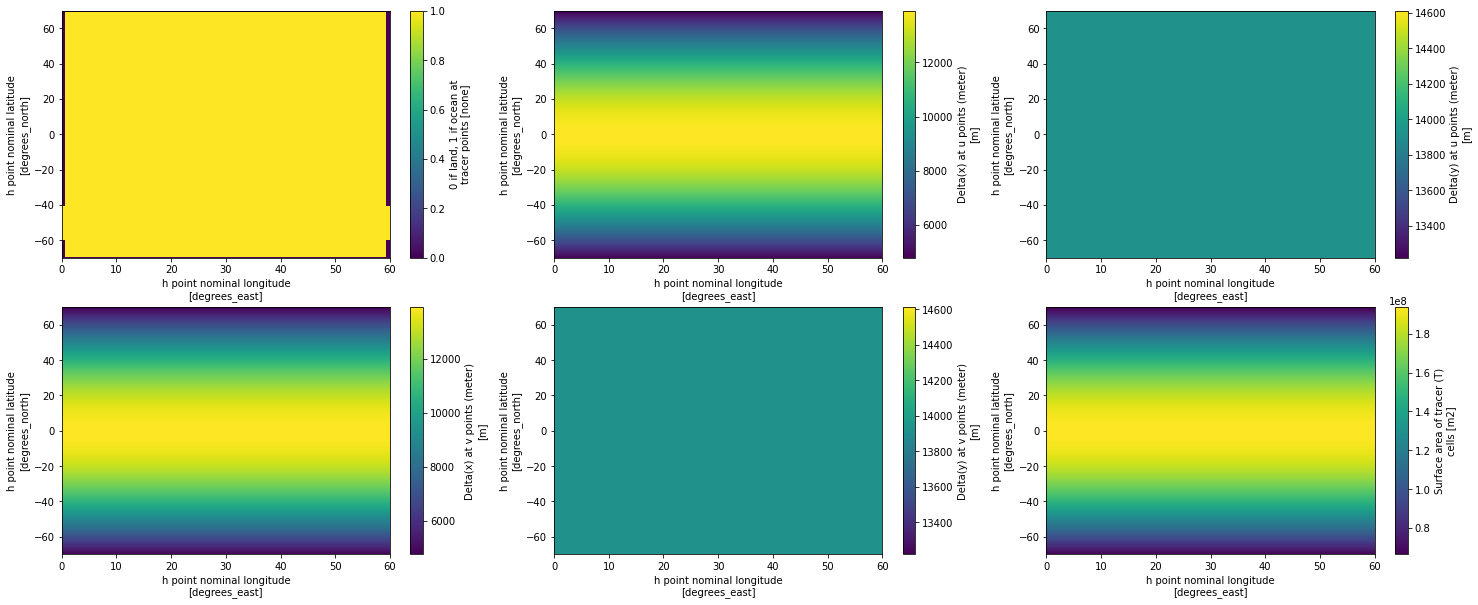

In [34]:
fig,axs = plt.subplots(2,3,figsize=(25,10))
wet_mask.plot(ax=axs[0,0])
dxw.plot(ax=axs[0,1])
dyw.plot(ax=axs[0,2])
dxs.plot(ax=axs[1,0])
dys.plot(ax=axs[1,1])
area.plot(ax=axs[1,2])

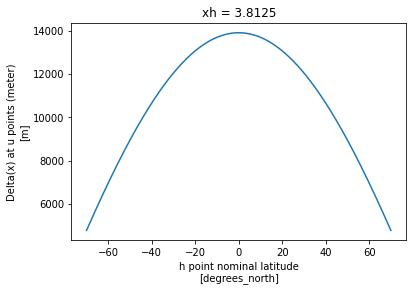

In [35]:
dxw.isel(xh=30).plot()

In [36]:
dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min())
dx_min = dx_min.values
dx_min

array(4759.08629892)

### Choose filter_scale = 16 * dx_min

In [41]:
filter_scale = 16 * dx_min
filter_scale

76145.38078264688

In [42]:
list(gcm_filters.GridType)

[<GridType.CARTESIAN: 1>,
 <GridType.CARTESIAN_WITH_LAND: 2>,
 <GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>]

In [43]:
gcm_filters.required_grid_vars(gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND)

['wet_mask', 'dxw', 'dyw', 'dxs', 'dys', 'area']

## Filter on CPU

### Choose n_steps = 30

In [44]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=30,
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area}
)
filter

Filter(filter_scale=76145.38078264688, dx_min=array(4759.08629892), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=30, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

In [45]:
KE_filtered = filter.apply(av.KE, dims=['yh', 'xh'])

[########################################] | 100% Completed |  4min 13.5s
[########################################] | 100% Completed |  4min 13.9s


Text(0.5, 1.0, 'Difference')

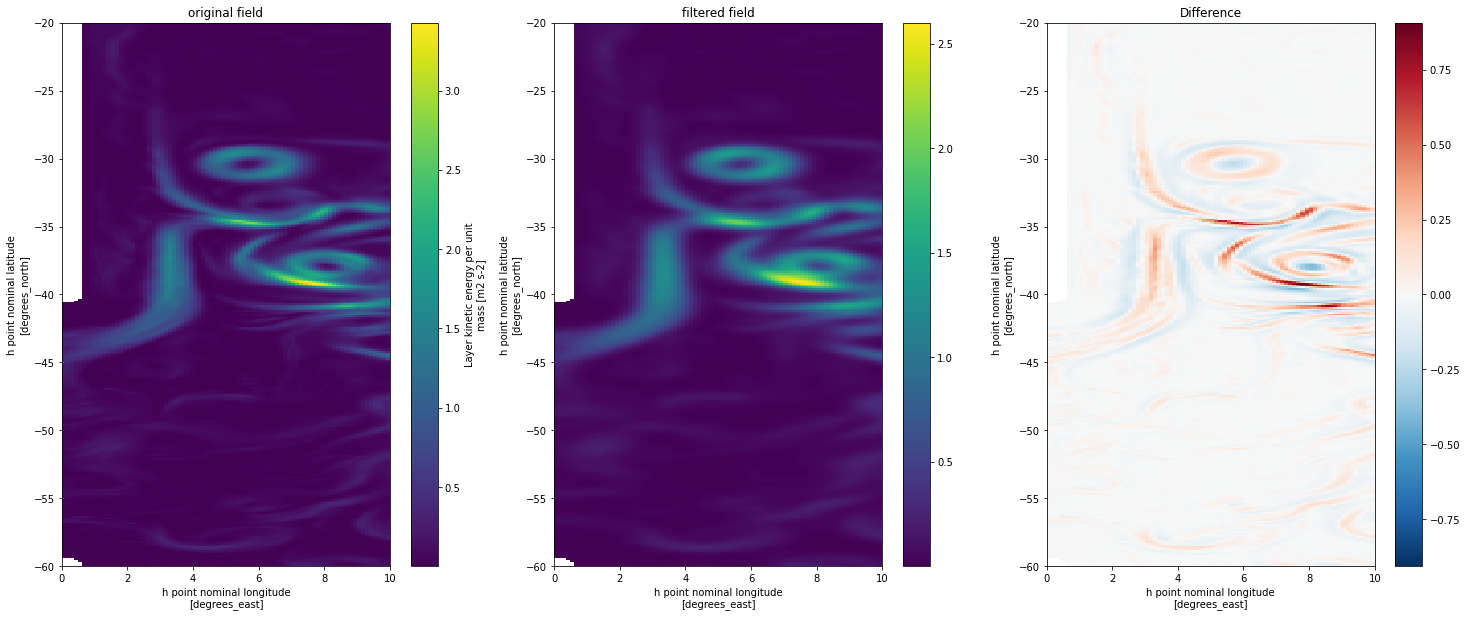

In [46]:
time = -1
layer = 0
xslice = slice(0,10)
yslice = slice(-60,-20)

fig,axs = plt.subplots(1,3,figsize=(25,10))
av.KE.isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[0])
axs[0].set_title('original field')
with ProgressBar():
    KE_filtered.isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[1])
axs[1].set_title('filtered field')
with ProgressBar():
    (av.KE - KE_filtered).isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[2])
axs[2].set_title('Difference')

Since this is a filter with **fixed filter scale** (= 16 * dx_min = 16 * 4.8 km), a smoother structure is most visible at the high latitudes, where the grid spacing is the smallest. The above figure zooms into a subregion of the ACC.

We will now move to a GPU, because it is much faster, so we can easily increase n_steps.

## Filter on GPU

### Make dask arrays with cupy blocks

In [47]:
wet_mask = wet_mask.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
wet_mask

<xarray.DataArray 'wet' (yh: 1120, xh: 480)>
dask.array<asarray, shape=(1120, 480), dtype=float64, chunksize=(1120, 480), chunktype=cupy.ndarray>
Coordinates:
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
Attributes:
    long_name:      0 if land, 1 if ocean at tracer points
    units:          none
    cell_methods:   time: point
    cell_measures:  area: area_t

In [48]:
dxw = dxw.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
dxw.data = dxw.data.map_blocks(cp.asarray)

dyw = dyw.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
dyw.data = dyw.data.map_blocks(cp.asarray)

dxs = dxs.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
dxs.data = dxs.data.map_blocks(cp.asarray)

dys = dys.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
dys.data = dys.data.map_blocks(cp.asarray)

area = area.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
area.data = area.data.map_blocks(cp.asarray)

In [49]:
KE = av.KE.copy()
KE.data = KE.data.map_blocks(cp.asarray)
KE

<xarray.DataArray 'KE' (time: 100, zl: 15, yh: 1120, xh: 480)>
dask.array<asarray, shape=(100, 15, 1120, 480), dtype=float32, chunksize=(20, 15, 1120, 480), chunktype=cupy.ndarray>
Coordinates:
  * yh       (yh) float64 -69.94 -69.81 -69.69 -69.56 ... 69.69 69.81 69.94
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * time     (time) float64 3.1e+04 3.101e+04 3.101e+04 ... 3.149e+04 3.15e+04
  * xh       (xh) float64 0.0625 0.1875 0.3125 0.4375 ... 59.69 59.81 59.94
Attributes:
    long_name:      Layer kinetic energy per unit mass
    units:          m2 s-2
    cell_methods:   area:mean zl:mean yh:mean xh:mean time: mean
    cell_measures:  area: area_t
    time_avg_info:  average_T1,average_T2,average_DT

### Choose n_steps = 50

In [51]:
filter = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    n_steps=50,
    grid_type=gcm_filters.GridType.IRREGULAR_CARTESIAN_WITH_LAND,
    grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area}
)
filter

Filter(filter_scale=76145.38078264688, dx_min=array(4759.08629892), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=50, grid_type=<GridType.IRREGULAR_CARTESIAN_WITH_LAND: 3>)

In [52]:
KE_filtered = filter.apply(KE, dims=['yh', 'xh'])

[########################################] | 100% Completed |  4.8s
[########################################] | 100% Completed |  3.7s


Text(0.5, 1.0, 'Difference')

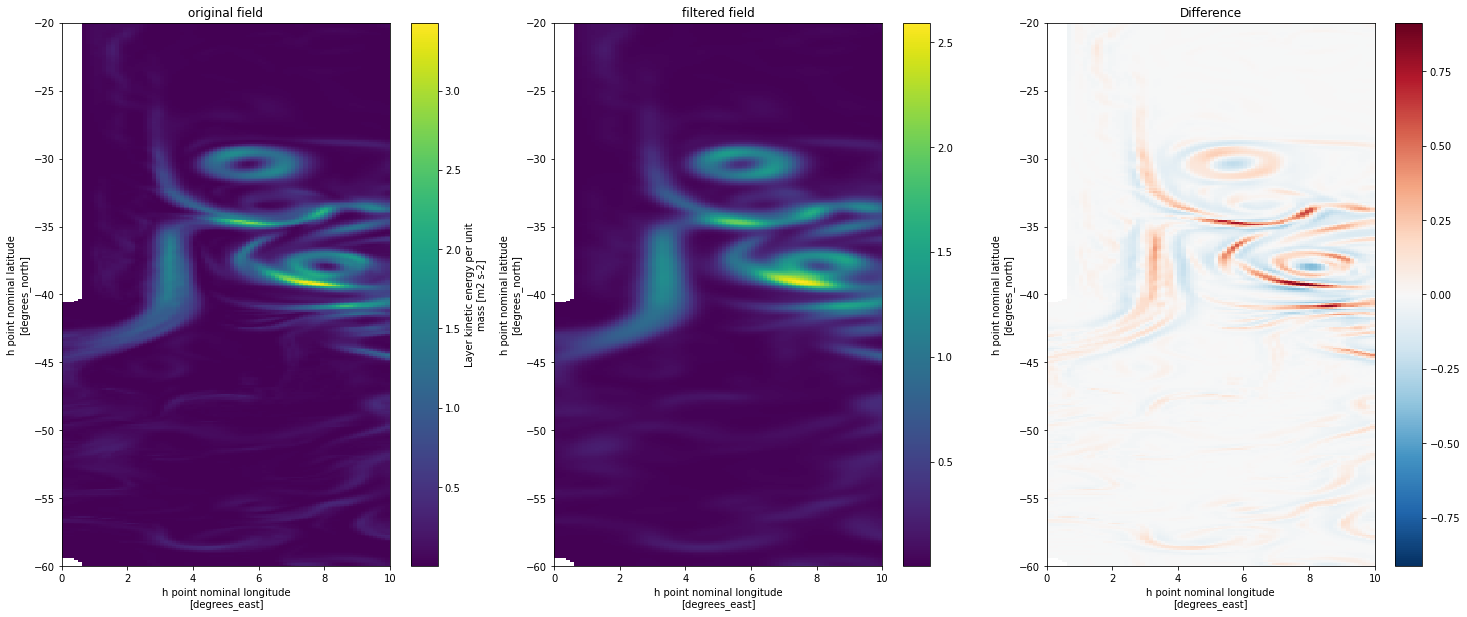

In [53]:
time = -1
layer = 0
xslice = slice(0,10)
yslice = slice(-60,-20)

fig,axs = plt.subplots(1,3,figsize=(25,10))
KE.isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[0])
axs[0].set_title('original field')
with ProgressBar():
    KE_filtered.isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[1])
axs[1].set_title('filtered field')
with ProgressBar():
    (KE - KE_filtered).isel(time=time,zl=layer).sel(xh=xslice,yh=yslice).plot(ax=axs[2])
axs[2].set_title('Difference')